In [1]:
# %%writefile Ind_xxxxx.py

import sys
import os 
module_path = os.path.abspath(os.path.join('..')) 
if module_path not in sys.path: 
    sys.path.append(module_path)

import numpy as np
import pandas as pd


import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import QUANTAXIS as QA

import tools.Sample_Tools as smpl
import tools.Pretreat_Tools as pretreat

import EAST.Fetcher_EM as east

from base.JuUnits import excute_for_multidates

E:\PyProjects\IndicatorLab\EAST\Crawler_Block_East.py:41: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import trange, tqdm


In [8]:
from tools.Cacher import (CACHE_TYPE, save_cache,load_cache_adv,load_cache)

tail = False
if tail:
    file = 'all_tail_qfq'
else:
    file = 'all_train_qfq'
    
df_all = load_cache(file,cache_type=CACHE_TYPE.STOCK).sort_index()
smpl.optimize_data_type(df_all)

data_ = df_all

year1 = '2017'
year2 = '2018'
data_ = df_all.loc[year1+'-01-03':year2+'-12-31']
codes = data_.index.get_level_values(1).unique()
dates = data_.index.get_level_values(0).unique()

In [239]:
# df_all1 = load_cache('all_train_qfq',cache_type=CACHE_TYPE.STOCK).sort_index()
# df_all2 = load_cache('all_tail_qfq',cache_type=CACHE_TYPE.STOCK).sort_index()
# df_all = pd.concat([df_all1,df_all2],axis=0).sort_index()

data_ = df_all

year1 = '2016'
year2 = '2022'
data_ = df_all.loc[year1+'-01-03':year2+'-12-31']
codes = data_.index.get_level_values(1).unique()
dates = data_.index.get_level_values(0).unique()

In [9]:
# 个股情绪

# turnover = data_['volume'] / (data_['lshares'] *100) 

# turnover_mean_month = excute_for_multidates(turnover, lambda x:x.rolling(22).mean(), level='code')
# turnover_mean_week = excute_for_multidates(turnover, lambda x:x.rolling(5).mean(), level='code')
# turnover_unknown = turnover_mean_week/turnover_mean_month

# overnight_ret = excute_for_multidates(data_, lambda x:(x['open']/x['close'].shift(1))-1, level='code')
# turnover_rate = excute_for_multidates(turnover, lambda x: x-x.shift(1), level='code')
# # 指令不平衡(净流入额/总成交额)  代理达成一致意见所需时间
# buy_sell_belance = intraday_df_tmp['bs_balance']

# ret = smpl.get_current_return(data_, 'close')
# ret_std5 = excute_for_multidates(ret, lambda x:x.rolling(5).std(), level='code')

def calc_rs(x):
    down = (x<0).sum()
    if down==0:
        rs = float(x.shape[0])
    else:
        up = (x>0).sum()
        rs = up/down
    rsi=100-100/(1+rs)
    return rsi
    
# *投资者达成一致意见所需时间 = (最高价 - 开盘价) / (收盘价 - 开盘价)
# *相对强弱指标（RSI）：计算公式：RSI=100-100/(1+RS)
   # 相对强度(RS)=一定时期收盘指数涨数的平均值/一定时期收盘指数跌数的平均值，主要和价格的收盘平均值有关，可以表现股价的运动速率。

# RSI_6 = excute_for_multidates(ret, lambda x:x.rolling(6).apply(lambda xx:calc_rs(xx)), level='code')
# RSI_12 = excute_for_multidates(ret, lambda x:x.rolling(12).apply(lambda xx:calc_rs(xx)), level='code')
# RSI_CD = RS_6-RS_12

# *随机指标（KD）
# C为当天的收；
# UP:=HHV(H,20);
# DN:=LLV(L,20);
# RSV:=(C-DN)/(UP-DN)*100;
# K:SMA(RSV,3,1);
# D:SMA(K,3,1);

def calc_kd(df):
    up = df.high.rolling(20).max()
    dn = df.low.rolling(20).min()
    c = df.close
    rsv = (c-dn)/(up-dn) * 100
    return rsv
    
KD = excute_for_multidates(data_, lambda xs:calc_kd(xs), level='code')



# volume





In [12]:
# KD[20:60]

In [4]:
# RSI_CD[24200:24260]

In [529]:
def calc_rs(x):
    down = (x<0).sum()
    if down==0:
        return float(x.shape[0])
    else:
        up = (x>0).sum()
        return up/down
    
excute_for_multidates(ret.loc[(slice(None),'000002'),], lambda x:x.rolling(12).apply(lambda xx:calc_rs(xx)), level='code')

date        code  
2016-07-04  000002         NaN
2016-07-05  000002         NaN
2016-07-06  000002         NaN
2016-07-07  000002         NaN
2016-07-08  000002         NaN
                        ...   
2022-12-26  000002    0.714286
2022-12-27  000002    0.714286
2022-12-28  000002    1.000000
2022-12-29  000002    0.714286
2022-12-30  000002    1.000000
Name: ret, Length: 1577, dtype: float64

In [492]:
def get_intraday_indicator_by_code(code,st='2016-03-01',en='2020-12-31',fr=QA.FREQUENCE.FIVE_MIN):
    def calc(varaints_daily):
        close = varaints_daily.close
        ret = (close/close.shift(1) - 1)#.dropna()
        #######指令平衡###########################
        #已实现方差 RealizedVolatility
        net_mf_amount = varaints_daily.amount[ret > 0].sum()
        neg_amount = varaints_daily.amount[ret < 0].sum()
        amount = neg_amount+net_mf_amount
        if amount == 0:
            bs_balance = 0
        else:
            bs_balance = (net_mf_amount/amount)-0.5
        ##########################################
        
        
        # print()
        return bs_balance

    stock_df = smpl.get_data(code, start=st, end=en, gap=None, freq=fr)
    if stock_df is None:
        return None
    stock_df = stock_df.data
    columns = ['close','volume','amount']
    var = stock_df[columns]
    var_unindex = var.reset_index()

    res = var_unindex[columns].groupby(var_unindex.datetime.dt.to_period("D"),group_keys=False).apply(lambda x: calc(x))
    res_df = pd.DataFrame(res.to_list(),
                          index=pd.MultiIndex.from_arrays([res.index.to_timestamp(),[code]*len(res.index)]),
                          columns=['bs_balance'])
    
    return res_df

intraday_df_tmp = pd.DataFrame()
for code in ['002415']:
    res = get_intraday_indicator_by_code(code,dates.min().strftime('%Y-%m-%d'),dates.max().strftime('%Y-%m-%d'))
    if res is None:
        continue
    intraday_df_tmp = pd.concat([intraday_df_tmp,res],axis=0)

In [15]:
# a = smpl.get_index_data(['880810','880811'], start=dates.min(), end=dates.max(), gap=None).data
# a = turnover_unknown.loc[(slice(None),'000001')]
a = KD.loc[(slice(None),'000002'),]
d = a.index.get_level_values(0).unique()
# bench = smpl.get_benchmark(name='沪深300', start=d.min(), end=d.max()).data
bench = data_.loc[(slice(None),'000002'),]

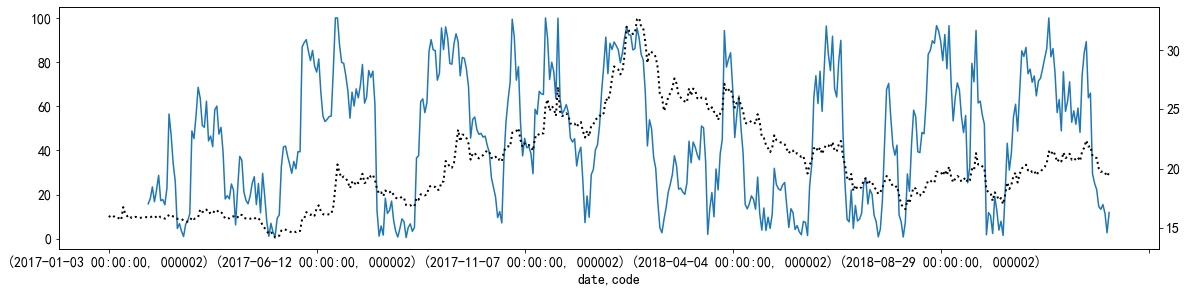

In [16]:
fig = plt.figure(figsize=(1420/72,320/72))
# a['close'].groupby(level=1).apply(lambda x:x.plot())
a.plot()
# ax2 = plt.gca()
# ax2.plot(range(bench.shape[0]),(0.5*a['close'].loc[(slice(None),'880876')].values+0.5*a['close'].loc[(slice(None),'880877')]).values,linewidth=2,color="red")



ax3 = plt.gca().twinx()
ax3.plot(range(bench.shape[0]),bench['close'].values,linestyle=":", linewidth=2,color="black",label='bm')
# ax3.plot(bench.index.get_level_values(0).values,bench['close'].values,linestyle=":", linewidth=2,color="black",label='bm')


In [407]:
data_

open       high        low      close    volume  \
date       code                                                           
2016-01-04 000001   8.845516   8.867629   8.277928   8.351641  563497.0   
           000004  45.900000  46.600000  41.310000  41.310000   22833.0   
           000006   9.204111   9.252300   8.320645   8.336708  232852.0   
           000008  11.674633  11.674633  10.416760  10.426587  140399.0   
           000009  10.828059  10.828059   9.742841   9.742841  672531.0   
...                      ...        ...        ...        ...       ...   
2022-12-30 605580   8.150633   8.280879   8.088938   8.274024    7771.0   
           605588  28.522758  28.732264  28.373110  28.732264    2557.0   
           605589  21.483000  21.651300  20.770200  21.176100   77000.0   
           605598  25.300000  25.500000  24.670000  24.900000   22984.0   
           605599   9.579020   9.828824   9.511765   9.780784   65106.0   

                         amount       adj        shares       lshares  \
date       code                                                         
2016-01-04 000001  6.603761e+08  0.737126  1.430868e+06  1.180406e+06   
           000004  9.767486e+07  1.000000  8.397668e+03  8.296188e+03   
           000006  2.546398e+08  0.803151  1.349995e+05  1.340266e+05   
           000008  1.570146e+08  0.982713  2.409433e+05  6.401386e+04   
           000009  1.130235e+09  0.602899  1.592107e+05  1.489669e+05   
...                         ...       ...           ...           ...   
2022-12-30 605580  9.326484e+06  0.685503  2.000000e+04  5.111000e+03   
           605588  7.322457e+06  0.997648  7.309956e+03  2.309956e+03   
           605589  1.638851e+08  0.990000  7.828768e+04  6.152118e+04   
           605598  5.754628e+07  1.000000  1.727435e+04  5.264347e+03   
           605599  6.582705e+07  0.960784  7.777778e+04  5.866778e+04   

                   market_value  liquidity_market_value industry  
date       code                                                   
2016-01-04 000001  1.195009e+11            9.858323e+10    股份制银行  
           000004  3.469077e+09            3.427155e+09     基础软件  
           000006  1.125451e+10            1.117341e+10     住宅开发  
           000008  2.512216e+10            6.674461e+09     轨交设备  
           000009  1.551165e+10            1.451361e+10    电池化学品  
...                         ...                     ...      ...  
2022-12-30 605580  1.654805e+09            4.228854e+08     热力服务  
           605588  2.100316e+09            6.637027e+08     光学元件  
           605589  1.657828e+10            1.302779e+10     合成树脂  
           605598  4.301313e+09            1.310822e+09   其他专业工程  
           605599  7.607277e+09            5.738169e+09     钟表珠宝  

[4463316 rows x 12 columns]

In [357]:
a.corr(bench['close'])

0.003965855405873596

In [243]:
(a['close'].loc[(slice(None),'880811')]).corr(bench['close'])

0.6600497777563527

In [200]:
(a['close'].loc[(slice(None),'880008')]).corr(a['close'].loc[(slice(None),'880018')])

0.9785016249762243

In [181]:
a

open    close     high      low       vol        amount  \
date       code                                                                 
2020-01-02 880792  1009.24  1024.91  1026.35   999.01  219724.0  3.138752e+10   
           880793  1006.64  1017.44  1018.68  1001.48  156419.0  3.321133e+10   
2020-01-03 880792  1027.13  1027.24  1034.17  1018.87  197432.0  3.076488e+10   
           880793  1017.82  1011.16  1018.91  1005.58  135738.0  2.983738e+10   
2020-01-06 880792  1021.00  1038.79  1050.77  1017.73  236023.0  3.636908e+10   
...                    ...      ...      ...      ...       ...           ...   
2022-12-28 880793  1322.33  1313.08  1322.33  1303.79   40154.0  1.606760e+10   
2022-12-29 880792  1028.20  1033.38  1041.93  1026.62   36590.0  1.044061e+10   
           880793  1310.77  1316.51  1327.66  1308.42   42718.0  1.672669e+10   
2022-12-30 880792  1037.37  1039.74  1045.77  1033.95   38984.0  1.163942e+10   
           880793  1320.19  1316.00  1330.66  1314.36   41155.0  1.585119e+10   

                   up_count  down_count    date_stamp    volume  
date       code                                                  
2020-01-02 880792        86          12  1.577894e+09  219724.0  
           880793        77          19  1.577894e+09  156419.0  
2020-01-03 880792        44          51  1.577981e+09  197432.0  
           880793        41          59  1.577981e+09  135738.0  
2020-01-06 880792        56          36  1.578240e+09  236023.0  
...                     ...         ...           ...       ...  
2022-12-28 880793        27          73  1.672157e+09   40154.0  
2022-12-29 880792        44          56  1.672243e+09   36590.0  
           880793        52          47  1.672243e+09   42718.0  
2022-12-30 880792        52          43  1.672330e+09   38984.0  
           880793        41          56  1.672330e+09   41155.0  

[1456 rows x 10 columns]

In [96]:
a['close'].loc[(slice(None),'880780')]

date
2019-08-15    1017.51
2019-08-16    1024.67
2019-08-19    1052.96
2019-08-20    1053.36
2019-08-21    1061.13
               ...   
2020-12-25     860.03
2020-12-28     864.61
2020-12-29     825.27
2020-12-30     848.42
2020-12-31     876.57
Name: close, Length: 336, dtype: float64

In [ ]:
# 市场情绪
# n=east.fetch_north_deal_day(direct='north_', start=dates.min(), end=dates.max()).data
# s=east.fetch_north_deal_day(direct='south_', start=dates.min(), end=dates.max()).data
#~ 880780 融资增加 2019开始
#~ 880792 基金增仓 2020
#~ 880793 基金减仓 2020
#~ 880751 昨日跌停# 880863  昨日涨停 # 880876 户数增加 # 880877 户数减少
#~ 880752 昨曾跌停# 880874  昨曾涨停
#~ 880008 全Ａ等权
#~ 880018 主板等权


# 880990 TDX 金融 
# 880005 涨跌家数 收=涨数，开=跌数
# 880006 停板家数 收=涨停数，开=跌停数，高=最大涨停数

# 4.简易市场情绪
# 每日涨停/跌停数

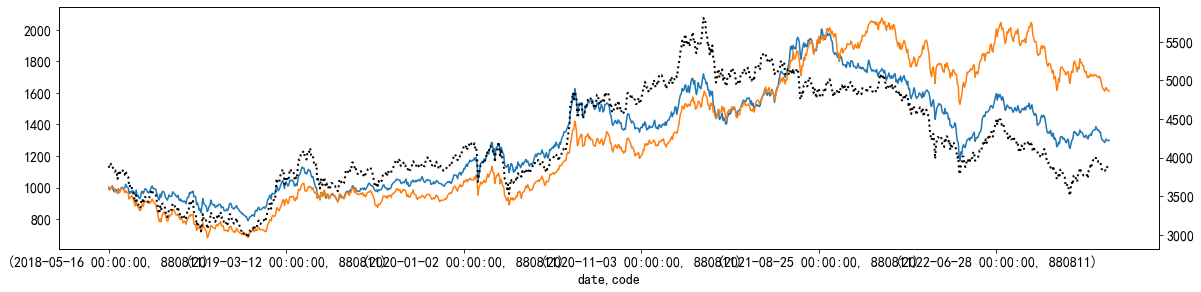

In [360]:
a = smpl.get_index_data(['880810','880811'], start=dates.min(), end=dates.max(), gap=None).data
d = a.index.get_level_values(0).unique()
bench = smpl.get_benchmark(name='沪深300', start=d.min(), end=d.max()).data

fig = plt.figure(figsize=(1420/72,320/72))
a['close'].groupby(level=1).apply(lambda x:x.plot())


ax3 = plt.gca().twinx()
ax3.plot(range(bench.shape[0]),bench['close'].values,linestyle=":", linewidth=2,color="black",label='bm')
# ax3.plot(bench.index.get_level_values(0).values,bench['close'].values,linestyle=":", linewidth=2,color="black",label='bm')


In [ ]:
import torch
import torch.nn as nn

# x_train = torch.from_numpy(x_train).type(torch.Tensor)
# x_test = torch.from_numpy(x_test).type(torch.Tensor)
# # 真实的数据
# y_train_lstm = torch.from_numpy(y_train).type(torch.Tensor)
# y_test_lstm = torch.from_numpy(y_test).type(torch.Tensor)

# 输入的维度为1，只有Close收盘价
input_dim = 1
# 隐藏层特征的维度
hidden_dim = 32
# 循环的layers
num_layers = 2
# 预测后一天的收盘价
output_dim = 1
num_epochs = 100


class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :])
        return out



In [ ]:
model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
criterion = torch.nn.MSELoss()
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

In [ ]:
import time

hist = np.zeros(num_epochs)
start_time = time.time()
lstm = []

for t in range(num_epochs):
    y_train_pred = model(x_train)

    loss = criterion(y_train_pred, y_train_lstm)
    print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()

    optimiser.zero_grad()
    loss.backward()
    optimiser.step()

training_time = time.time() - start_time
print("Training time: {}".format(training_time))

predict = pd.DataFrame(scaler.inverse_transform(y_train_pred.detach().numpy()))
print(predict)  # 预测值
original = pd.DataFrame(scaler.inverse_transform(y_train_lstm.detach().numpy()))
print(original)  # 真实值



In [ ]:
import seaborn as sns
sns.set_style("darkgrid")

fig = plt.figure()
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plt.subplot(1, 2, 1)
ax = sns.lineplot(x = original.index, y = original[0], label="Data", color='royalblue')
ax = sns.lineplot(x = predict.index, y = predict[0], label="Training Prediction (LSTM)", color='tomato')
print(predict.index)
print("aaaa")
print(predict[0])


ax.set_title('Stock price', size = 14, fontweight='bold')
ax.set_xlabel("Days", size = 14)
ax.set_ylabel("Cost (USD)", size = 14)
ax.set_xticklabels('', size=10)


plt.subplot(1, 2, 2)
ax = sns.lineplot(data=hist, color='royalblue')
ax.set_xlabel("Epoch", size = 14)
ax.set_ylabel("Loss", size = 14)
ax.set_title("Training Loss", size = 14, fontweight='bold')
fig.set_figheight(6)
fig.set_figwidth(16)
plt.show()
